# Bayesian Room‑Occupancy Playground  
Interactive notebook that demonstrates the weighted, time‑decaying Bayesian fusion logic for PIR motion sensors described in chat.  Tweak the parameters (sensor weights, half‑life, event schedule) and re‑run cells to see how the overall posterior evolves.

In [71]:
import math
import random
import time

import matplotlib.pyplot as plt

In [72]:
from dataclasses import dataclass, field


@dataclass
class Prior:
    """Prior probability of the entity being active."""

    prob_given_true: float  # P(E | H)
    prob_given_false: float  # P(E | ¬H)


@dataclass
class Decay:
    """Decay timer for the entity."""

    last_trigger_ts: float = field(default_factory=time.time)
    half_life: float = 300.0  # seconds
    is_decaying: bool = False

    @property
    def decay_factor(self) -> float:
        """Decay factor for the entity."""

        if not self.is_decaying:
            return 1.0
        age = time.time() - self.last_trigger_ts
        if age <= 0:
            return 1.0
        return math.pow(0.5, age / self.half_life)


@dataclass
class Entity:
    """Type for sensor state information."""

    entity_id: str
    prior: Prior
    weight: float = 1.0  # static reliability (0‑1)
    is_active: bool | None = None
    decay: Decay = field(default_factory=Decay)

In [73]:
EPS = 1e-12


def bayesian_probability(
    *,
    prior: float,
    prob_given_true: float,
    prob_given_false: float,
    is_active: bool | None = None,
    weight: float = 1.0,
    decay_factor: float = 1.0,
) -> float:
    """Weighted, time-decaying Bayesian update step."""
    # early exits
    if is_active is None or weight == 0.0 or decay_factor == 0.0:
        return prior

    if is_active:
        lr = (prob_given_true + EPS) / (prob_given_false + EPS)
    else:
        lr = (1.0 - prob_given_true + EPS) / (1.0 - prob_given_false + EPS)

    lr **= weight * decay_factor
    prior_odds = prior / (1.0 - prior + EPS)
    post_odds = prior_odds * lr
    return post_odds / (1.0 + post_odds)


def overall_probability(entities: dict[str, Entity], prior: float) -> float:
    """Overall probability of the area being occupied."""

    posterior = prior
    for e in entities.values():
        observed = (
            True
            if e.is_active or e.decay.is_decaying
            else False
            if e.is_active is False and not e.decay.is_decaying
            else None
        )
        posterior = bayesian_probability(
            prior=posterior,
            prob_given_true=e.prior.prob_given_true,
            prob_given_false=e.prior.prob_given_false,
            is_active=observed,
            weight=e.weight,
            decay_factor=e.decay.decay_factor if e.decay.is_decaying else 1.0,
        )
    return posterior

In [74]:
def update_entities(entities: dict[str, Entity], motion_now: set[str]):
    """Update the entities based on the motion_now set."""

    now = time.time()
    for eid, ent in entities.items():
        if eid in motion_now:
            ent.is_active = True
            ent.decay.is_decaying = True
            ent.decay.last_trigger_ts = now
        else:
            ent.is_active = False
            if ent.decay.decay_factor < 0.05:
                ent.decay.is_decaying = False

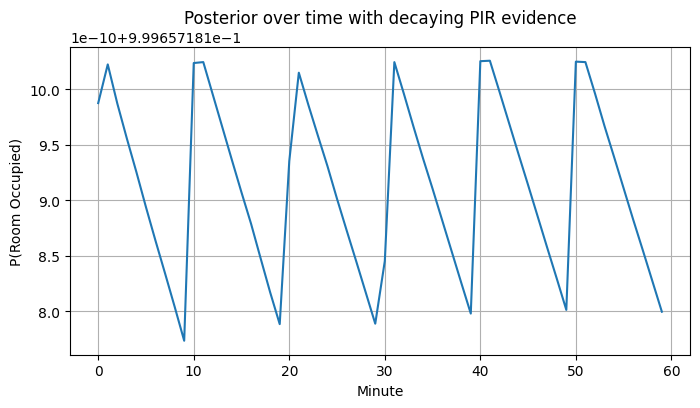

In [88]:
# --- experiment parameters ---
prior_room_empty = 0.8  # prior that room is empty

priors = Prior(
    prob_given_true=0.9, prob_given_false=0.1
)  # same for all sensors for simplicity

entities = {
    f"pir_{i}": Entity(entity_id=f"pir_{i}", prior=priors, weight=1.0) for i in range(3)
}

# Half‑life configuration
for e in entities.values():
    e.decay.half_life = 300  # 5 minutes

# --- simulate 60 minutes with random motion bursts ---
timeline = []
posterior_series = []

start = time.time()
sim_minutes = 60

for minute in range(sim_minutes):
    # synthetic motion: bursts every 10 minutes lasting 2 minutes
    burst = (minute % 10) < 2
    motion_now = {eid for eid in entities if burst and random.random() < 0.8}

    update_entities(entities, motion_now)
    posterior = overall_probability(entities, prior_room_empty)

    timeline.append(minute)
    posterior_series.append(posterior)

# --- plot ---
plt.figure(figsize=(8, 4))
plt.plot(timeline, posterior_series)
plt.xlabel("Minute")
plt.ylabel("P(Room Occupied)")
plt.title("Posterior over time with decaying PIR evidence")
plt.grid(True)
plt.show()